In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

In [2]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)

{'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv5_3': <tf.Tensor 'Relu_14:0' shape=(1, 19, 25, 512) dtype=float32>, 'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv5_1': <tf.Tensor 'Relu_12:0' shape=(1, 19, 25, 512) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv5_4': <tf.Tensor 'Relu_15:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv4_3': <tf.Tensor 'Relu_10:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv5_2': <tf.Tensor 'Relu_13:0' shape=(1, 19, 25, 512) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' sha

In [3]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """    
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.transpose(tf.reshape(a_C,[-1]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G,[-1]))
    
    # compute the cost with tensorflow (≈1 line)
    J_content = tf.reduce_sum(tf.square( tf.subtract(a_C_unrolled, a_G_unrolled)))/(4*n_H* n_W* n_C )   
    
    return J_content

In [4]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """   
   
    GA = tf.matmul(A,tf.transpose(A))   
    
    return GA

In [5]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """    
   
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    #print(a_S.shape)
    a_S = tf.transpose(tf.reshape(a_S,[ n_H*n_W,n_C]))
    a_G = tf.transpose(tf.reshape(a_G,[ n_H*n_W,n_C]))
    #print(a_S.shape)

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = tf.reduce_sum(tf.square( tf.subtract(GS, GG)))/(4*n_C*n_C*(n_H* n_W)*(n_H* n_W)  )
    
    return J_style_layer

In [6]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [7]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [8]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """      
    J = alpha*J_content+beta*J_style 
    
    return J

C:\Users\Andi\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
C:\Users\Andi\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


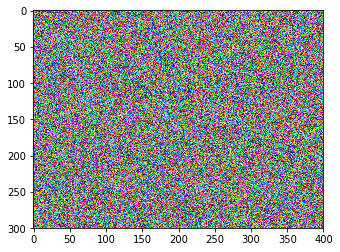

In [9]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

content_image = scipy.misc.imread("images/Bild 015.jpg")
content_image = reshape_and_normalize_image(content_image)

style_image = scipy.misc.imread("images/turner_Waves_Breaking.jpg")
style_image = reshape_and_normalize_image(style_image)

generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [10]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [11]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [12]:
J = total_cost(J_content, J_style)

In [13]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

In [14]:
def model_nn(sess, input_image, num_iterations = 5000):
    
    # Initialize global variables (you need to run the session on the initializer)    
    sess.run(tf.global_variables_initializer())
        
    # Run the noisy input image (initial generated image) through the model. Use assign().    
    sess.run(model['input'].assign(input_image))    
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost        
        _ = sess.run(train_step)
                
        # Compute the generated image by running the session on the current model['input']        
        generated_image = sess.run(model['input'])        

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [15]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 1.31067e+09
content cost = 9512.1
style cost = 3.27644e+07
Iteration 20 :
total cost = 2.6624e+08
content cost = 14843.5
style cost = 6.65229e+06
Iteration 40 :
total cost = 9.45638e+07
content cost = 16247.0
style cost = 2.36003e+06
Iteration 60 :
total cost = 5.08921e+07
content cost = 16851.2
style cost = 1.26809e+06
Iteration 80 :
total cost = 3.49656e+07
content cost = 17126.1
style cost = 869859.0
Iteration 100 :
total cost = 2.7241e+07
content cost = 17297.1
style cost = 676701.0
Iteration 120 :
total cost = 2.2602e+07
content cost = 17412.1
style cost = 560698.0
Iteration 140 :
total cost = 1.93985e+07
content cost = 17506.6
style cost = 480585.0
Iteration 160 :
total cost = 1.69955e+07
content cost = 17587.4
style cost = 420491.0
Iteration 180 :
total cost = 1.5125e+07
content cost = 17648.5
style cost = 373712.0
Iteration 200 :
total cost = 1.36189e+07
content cost = 17697.2
style cost = 336049.0
Iteration 220 :
total cost = 1.23773e+07
content cost

Iteration 1920 :
total cost = 1.1538e+06
content cost = 18293.0
style cost = 24271.8
Iteration 1940 :
total cost = 982041.0
content cost = 18273.8
style cost = 19982.6
Iteration 1960 :
total cost = 915036.0
content cost = 18267.7
style cost = 18309.0
Iteration 1980 :
total cost = 944159.0
content cost = 18271.0
style cost = 19036.2
Iteration 2000 :
total cost = 878085.0
content cost = 18253.2
style cost = 17388.8
Iteration 2020 :
total cost = 1.05833e+06
content cost = 18272.2
style cost = 21890.1
Iteration 2040 :
total cost = 861764.0
content cost = 18255.8
style cost = 16980.1
Iteration 2060 :
total cost = 1.02245e+06
content cost = 18270.2
style cost = 20993.8
Iteration 2080 :
total cost = 1.11538e+06
content cost = 18218.2
style cost = 23329.8
Iteration 2100 :
total cost = 847259.0
content cost = 18256.2
style cost = 16617.4
Iteration 2120 :
total cost = 1.18804e+06
content cost = 18267.0
style cost = 25134.1
Iteration 2140 :
total cost = 1.04416e+07
content cost = 18489.3
style co

Iteration 3880 :
total cost = 5.58923e+07
content cost = 18593.5
style cost = 1.39266e+06
Iteration 3900 :
total cost = 9.14664e+06
content cost = 18920.4
style cost = 223936.0
Iteration 3920 :
total cost = 2.06586e+06
content cost = 18791.8
style cost = 46948.6
Iteration 3940 :
total cost = 1.43229e+06
content cost = 18772.2
style cost = 31114.1
Iteration 3960 :
total cost = 978137.0
content cost = 18691.5
style cost = 19780.5
Iteration 3980 :
total cost = 894521.0
content cost = 18650.7
style cost = 17700.4
Iteration 4000 :
total cost = 766549.0
content cost = 18635.5
style cost = 14504.9
Iteration 4020 :
total cost = 760233.0
content cost = 18596.9
style cost = 14356.6
Iteration 4040 :
total cost = 681448.0
content cost = 18592.5
style cost = 12388.1
Iteration 4060 :
total cost = 640327.0
content cost = 18561.5
style cost = 11367.8
Iteration 4080 :
total cost = 948567.0
content cost = 18599.3
style cost = 19064.3
Iteration 4100 :
total cost = 641810.0
content cost = 18543.7
style co

array([[[[-187.19943237, -194.67015076, -150.77693176],
         [ -48.68439484,  -74.16351318,  -68.44849396],
         [  96.06512451,  131.35826111,   66.69924164],
         ..., 
         [  32.77866745,   44.00315475,  -14.35177898],
         [  15.43347168,   44.47559357,  -24.56444931],
         [  26.76772499,   76.68741608,   -0.30147865]],

        [[  41.29921341,    8.29460335,   62.43595123],
         [  53.2479248 ,   33.27017975,   27.78165436],
         [  48.46947479,   67.28768921,  -45.12162781],
         ..., 
         [  66.41165924,   34.34918594,  -41.32367706],
         [  60.96061707,   50.83410645,  -48.71691513],
         [  46.92586136,   83.65939331,  -30.47020531]],

        [[  83.2583313 ,   76.45545959,   80.18845367],
         [  94.00292969,   71.61930084,  -23.47053719],
         [  56.70825195,   60.7146492 ,  -53.99786377],
         ..., 
         [  58.57591248,   38.19704819,  -31.13600922],
         [  66.48329163,   45.91766357,  -20.31162834],